# New Extraction date/timestamp parts (#2149)

In [1]:
# t.timestamp_of_birth - ibis.interval(1, 'D')
# Error: Unknown HTML element <int8> on line 1 
# in label of node 7208238078510608626

In [2]:
from datetime import datetime, date

import ibis
import numpy as np
import pandas as pd
# local
from settings import conf
from utils import cursor2df
from gen_data import salary_date, salary_date_schema

In [3]:
BACKENDS = ['omniscidb', 'postgres']
con = {
    backend: getattr(ibis, backend).connect(**conf[backend]) 
    for backend in BACKENDS
}

In [4]:
df_salary1 = salary_date()
print(df_salary1.dtypes)
df_salary1.info()

last_name                     object
salary                         int64
date_of_birth                 object
timestamp_of_birth    datetime64[ns]
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   last_name           4018 non-null   object        
 1   salary              4018 non-null   int64         
 2   date_of_birth       4018 non-null   object        
 3   timestamp_of_birth  4018 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 125.7+ KB


In [5]:
sch = salary_date_schema()
sch

ibis.Schema {  
  last_name           string
  salary              float64
  date_of_birth       date
  timestamp_of_birth  timestamp
}

In [6]:
table_name = 'salary'
t = {}
params = {
    'postgres': {'if_exists': 'append'}
}

for backend in BACKENDS:
    if hasattr(con[backend], 'load_data'):
        con[backend].drop_table(table_name, force=True)
        con[backend].create_table(table_name, schema=sch)
        con[backend].load_data(table_name, df_salary1, **params.get(backend, {}))
    t[backend] = con[backend].table(table_name)

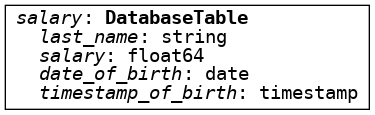

In [7]:
con['omniscidb'].table(table_name)

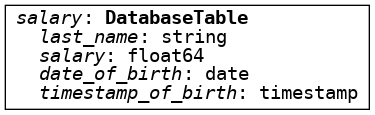

In [8]:
t['omniscidb']

In [9]:
t['omniscidb'].execute()

,last_name,salary,date_of_birth,timestamp_of_birth
0,Name 2010 1 1,2.010000e+10,2010-01-01,2010-01-01 01:01:01.010101
1,Name 2011 1 1,2.011000e+10,2011-01-01,2011-01-01 01:01:01.010101
2,Name 2012 1 1,2.012000e+10,2012-01-01,2012-01-01 01:01:01.010101
3,Name 2013 1 1,2.013000e+10,2013-01-01,2013-01-01 01:01:01.010101
4,Name 2014 1 1,2.014000e+10,2014-01-01,2014-01-01 01:01:01.010101
...,...,...,...,...
4013,Name 2016 12 31,2.016001e+10,2016-12-31,2016-12-31 12:12:12.121231
4014,Name 2017 12 31,2.017001e+10,2017-12-31,2017-12-31 12:12:12.121231
4015,Name 2018 12 31,2.018001e+10,2018-12-31,2018-12-31 12:12:12.121231
4016,Name 2019 12 31,2.019001e+10,2019-12-31,2019-12-31 12:12:12.121231


## Implementation check list

Check if extraction is working for OmniSciDB

- [x] YEAR
- [x] MONTH
- [x] DAY
- [x] HOUR
- [x] MINUTE
- [x] SECOND

Fix operations that are not working for OmniSciDB

- [x] MILLISECOND 

Add support for operations on OmniSciDB

- [x] DOW (full name and index)

Add new operations (core) and OmniSciDB support

- [x] QUARTER
- [x] MICROSECOND
- [x] ISODOW
- [x] DOY
- [x] QUARTERDAY
- [x] WEEK


In [10]:
_t = t['omniscidb']

In [11]:
expr = _t.timestamp_of_birth.second().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
expr.execute();

SELECT "timestamp_of_birth", EXTRACT(SECOND FROM "timestamp_of_birth") AS tmp
FROM salary


In [12]:
expr = _t.timestamp_of_birth.microsecond().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
expr.execute();

SELECT "timestamp_of_birth",
        mod(EXTRACT(MICROSECOND FROM "timestamp_of_birth"), 1000000) AS tmp
FROM salary


In [13]:
expr = _t.timestamp_of_birth.microsecond().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
# print(expr.execute())

SELECT "timestamp_of_birth",
        mod(EXTRACT(MICROSECOND FROM "timestamp_of_birth"), 1000000) AS tmp
FROM salary


In [14]:
expr = _t.timestamp_of_birth.millisecond().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
# print(expr.execute())

SELECT "timestamp_of_birth",
        mod(EXTRACT(MILLISECOND FROM "timestamp_of_birth"), 1000) AS tmp
FROM salary


In [15]:
# check datetime_part available
for m in [
    'year', 'month', 'day', 'hour', 'minute', 'second', 'millisecond'
]:
    print('checking', m, '...', end=' ')
    getattr(_t.timestamp_of_birth, m)().execute()
    print('ok')

# t.timestamp_of_birth.day_of_week()

checking year ... ok
checking month ... ok
checking day ... ok
checking hour ... ok
checking minute ... ok
checking second ... ok
checking millisecond ... ok


In [16]:
# new datetime_part
for m in [
    'day_of_year',
    'quarter',
    'week_of_year',
    'microsecond', 
]:
    print(' {} '.format(m).center(80, '.'))
    print('checking', m, '...')
    expr = getattr(_t.timestamp_of_birth, m)().name('tmp')
    expr = _t[expr]
    print(expr.compile())
    expr.execute()


................................. day_of_year ..................................
checking day_of_year ...
SELECT EXTRACT(DOY FROM "timestamp_of_birth") AS tmp
FROM salary
................................... quarter ....................................
checking quarter ...
SELECT EXTRACT(QUARTER FROM "timestamp_of_birth") AS tmp
FROM salary
................................. week_of_year .................................
checking week_of_year ...
SELECT
  CASE
    WHEN CAST(floor(((EXTRACT(DOY FROM "timestamp_of_birth") - (EXTRACT(ISODOW FROM "timestamp_of_birth") - 1 + 1)) + 10) / 7) AS SMALLINT) < 1 THEN CASE WHEN ((mod((((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 4)) - floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 100)) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 400), 7)) = 4) OR ((mod(((((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) + floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 4)) - 

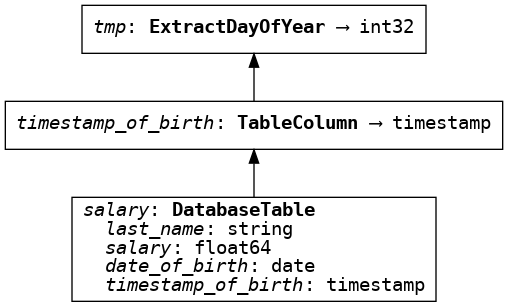

In [17]:
expr = _t.timestamp_of_birth.day_of_year().name('tmp')
expr

In [18]:
expr = _t.timestamp_of_birth.day_of_week.index().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
expr.execute();

SELECT "timestamp_of_birth",
       EXTRACT(ISODOW FROM "timestamp_of_birth") - 1 AS tmp
FROM salary


In [19]:
expr = _t.timestamp_of_birth.day_of_week.index().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
expr.execute();

SELECT "timestamp_of_birth",
       EXTRACT(ISODOW FROM "timestamp_of_birth") - 1 AS tmp
FROM salary


In [20]:
expr = _t.timestamp_of_birth.day_of_week.index().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
expr.execute();

SELECT "timestamp_of_birth",
       EXTRACT(ISODOW FROM "timestamp_of_birth") - 1 AS tmp
FROM salary


In [21]:
expr = _t.timestamp_of_birth.day_of_week.full_name().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
expr.execute();

SELECT "timestamp_of_birth",
  CASE EXTRACT(ISODOW FROM "timestamp_of_birth") - 1
    WHEN 0 THEN 'Monday'
    WHEN 1 THEN 'Tuesday'
    WHEN 2 THEN 'Wednesday'
    WHEN 3 THEN 'Thursday'
    WHEN 4 THEN 'Friday'
    WHEN 5 THEN 'Saturday'
    WHEN 6 THEN 'Sunday'
    ELSE ''
  END AS tmp
FROM salary


In [22]:
expr = _t.timestamp_of_birth.day_of_week.full_name().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
expr.execute();

SELECT "timestamp_of_birth",
  CASE EXTRACT(ISODOW FROM "timestamp_of_birth") - 1
    WHEN 0 THEN 'Monday'
    WHEN 1 THEN 'Tuesday'
    WHEN 2 THEN 'Wednesday'
    WHEN 3 THEN 'Thursday'
    WHEN 4 THEN 'Friday'
    WHEN 5 THEN 'Saturday'
    WHEN 6 THEN 'Sunday'
    ELSE ''
  END AS tmp
FROM salary


## Tests

In [23]:
pd.testing.assert_frame_equal(t['omniscidb'].execute(), t['postgres'].execute())

In [24]:
df = _t.execute()
df

,last_name,salary,date_of_birth,timestamp_of_birth
0,Name 2010 1 1,2.010000e+10,2010-01-01,2010-01-01 01:01:01.010101
1,Name 2011 1 1,2.011000e+10,2011-01-01,2011-01-01 01:01:01.010101
2,Name 2012 1 1,2.012000e+10,2012-01-01,2012-01-01 01:01:01.010101
3,Name 2013 1 1,2.013000e+10,2013-01-01,2013-01-01 01:01:01.010101
4,Name 2014 1 1,2.014000e+10,2014-01-01,2014-01-01 01:01:01.010101
...,...,...,...,...
4013,Name 2016 12 31,2.016001e+10,2016-12-31,2016-12-31 12:12:12.121231
4014,Name 2017 12 31,2.017001e+10,2017-12-31,2017-12-31 12:12:12.121231
4015,Name 2018 12 31,2.018001e+10,2018-12-31,2018-12-31 12:12:12.121231
4016,Name 2019 12 31,2.019001e+10,2019-12-31,2019-12-31 12:12:12.121231


### 1. day of year

In [25]:
for b in BACKENDS:
    try:
        print(' {} '.format(b).center(80, '='))
        expr = t[b].timestamp_of_birth.day_of_year()
        result = expr.execute().values
        expected = df.timestamp_of_birth.dt.dayofyear.values
        print(expr.compile())
        print('.' * 80)
        print('result:', result)
        print('expected:', expected)
        assert all((result == expected))
    except ibis.common.exceptions.OperationNotDefinedError:
        print('[WW] Not implemented.')
    except AssertionError:
        print('[EE] AssertionError')

================================== omniscidb ===================================
SELECT EXTRACT(DOY FROM "timestamp_of_birth") AS tmp
FROM salary
................................................................................
result: [  1   1   1 ... 365 365 366]
expected: [  1   1   1 ... 365 365 366]
=================================== postgres ===================================
SELECT CAST(EXTRACT(doy FROM t0.timestamp_of_birth) AS SMALLINT) AS tmp 
FROM salary AS t0
................................................................................
result: [  1   1   1 ... 365 365 366]
expected: [  1   1   1 ... 365 365 366]


### 2. week of year

In [26]:
for b in BACKENDS:
    try:
        print(' {} '.format(b).center(80, '='))
        expr = t[b].timestamp_of_birth.week_of_year()
        result = expr.execute().values
        expected = df.timestamp_of_birth.dt.weekofyear.values
        print(expr.compile())
        print('.' * 80)
        print('result:', result)
        print('expected:', expected)
        assert all((result == expected))
    except ibis.common.exceptions.OperationNotDefinedError:
        print('[WW] Not implemented.')
    except AssertionError:
        print('[EE] AssertionError')

================================== omniscidb ===================================
SELECT
  CASE
    WHEN CAST(floor(((EXTRACT(DOY FROM "timestamp_of_birth") - (EXTRACT(ISODOW FROM "timestamp_of_birth") - 1 + 1)) + 10) / 7) AS SMALLINT) < 1 THEN CASE WHEN ((mod((((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 4)) - floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 100)) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 400), 7)) = 4) OR ((mod(((((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) + floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 4)) - floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 100)) + floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 400), 7)) = 3) THEN 1 ELSE 0 END + 52
    WHEN CAST(floor(((EXTRACT(DOY FROM "timestamp_of_birth") - (EXTRACT(ISODOW FROM "timestamp_of_birth") - 1 + 1)) + 10) / 7) AS SMALLINT) > (CASE WHEN ((mod(((EXTRACT(YEAR FROM "timestamp_of_birth") +

### 3. quarter

In [27]:
for b in BACKENDS:
    try:
        print(' {} '.format(b).center(80, '='))
        expr = t[b].timestamp_of_birth.quarter()
        result = expr.execute().values
        expected = df.timestamp_of_birth.dt.quarter.values
        print(expr.compile())
        print('.' * 80)
        print('result:', result)
        print('expected:', expected)
        assert all((result == expected))
    except ibis.common.exceptions.OperationNotDefinedError:
        print('[WW] Not implemented.')
    except AssertionError:
        print('[EE] AssertionError')

================================== omniscidb ===================================
SELECT EXTRACT(QUARTER FROM "timestamp_of_birth") AS tmp
FROM salary
................................................................................
result: [1 1 1 ... 4 4 4]
expected: [1 1 1 ... 4 4 4]
=================================== postgres ===================================
SELECT CAST(EXTRACT(quarter FROM t0.timestamp_of_birth) AS SMALLINT) AS tmp 
FROM salary AS t0
................................................................................
result: [1 1 1 ... 4 4 4]
expected: [1 1 1 ... 4 4 4]


### 4. millisecond

In [39]:
# test for extra backends
from settings import post_connection_spark

extra_backends = ['mysql', 'sqlite', 'spark', 'pyspark']
salary_csv_path = '/tmp/salary.csv'

con.update({
    name: getattr(ibis, name).connect(**conf[name]) for name in extra_backends
})

post_connection_spark(con['pyspark'])
post_connection_spark(con['spark'])


df_salary1.to_csv(salary_csv_path, index=False)
params.update({
    'mysql': {'if_exists': 'append'},
    'sqlite': {'if_exists': 'append'},
})

for backend in extra_backends:
    print(' {} '.format(backend).center(80, '='))
    if hasattr(con[backend], 'load_data') or backend == 'pyspark':
        con[backend].drop_table(table_name, force=True)
        if backend == 'pyspark':
            try:
                con[backend]._create_table_or_temp_view_from_csv(
                    table_name, schema=sch, path=salary_csv_path
                )
            except:
                ...
        else:
            con[backend].create_table(table_name, schema=sch)
            con[backend].load_data(table_name, df_salary1, **params.get(backend, {}))
    try:
        t[backend] = con[backend].table(table_name)
        print('[II] Done.')
    except:
        print('[EE] Fail.')
    

==================================== mysql =====================================
[II] Done.
==================================== sqlite ====================================
[II] Done.
==================================== spark =====================================
[EE] Fail.
=================================== pyspark ====================================
[EE] Fail.


In [29]:
for b in BACKENDS + extra_backends:
    try:
        print(' {} '.format(b).center(80, '='))
        expr = t[b].timestamp_of_birth.millisecond()
        result = expr.execute()
        expected = (df.timestamp_of_birth.dt.microsecond // 1000).astype('int32')
        # expected = expected.apply(round).values
        print(expr.compile())
        print('.' * 80)
        print('result:', result.values)
        print('expected:', expected.values)
        np.testing.assert_equal(result.values, expected.values)
    except ibis.common.exceptions.OperationNotDefinedError:
        print('[WW] Not implemented.')
    except AssertionError as e:
        print('[EE] AssertionError: {}'.format(e))
    except Exception as e:
        print('[EE] Exception: {}'.format(e))

================================== omniscidb ===================================
SELECT  mod(EXTRACT(MILLISECOND FROM "timestamp_of_birth"), 1000) AS tmp
FROM salary
................................................................................
result: [ 10  10  10 ... 121 121 121]
expected: [ 10  10  10 ... 121 121 121]
=================================== postgres ===================================
SELECT CAST(floor(EXTRACT(millisecond FROM t0.timestamp_of_birth)) AS SMALLINT) %% %(param_1)s AS tmp 
FROM salary AS t0
................................................................................
result: [ 10  10  10 ... 121 121 121]
expected: [ 10  10  10 ... 121 121 121]
==================================== mysql =====================================
SELECT EXTRACT(microsecond FROM t0.timestamp_of_birth) %% %(param_1)s AS tmp 
FROM salary AS t0
................................................................................
result: [0 0 0 ... 0 0 0]
expected: [ 10  10  10 ... 121

In [40]:
# spark

expr = con['spark'].table('functional_alltypes').timestamp_col.millisecond()
print(expr.compile())
result = expr.execute()
print('result:', result.values)

SELECT extract(`timestamp_col`, 'millisecond') AS `tmp`
FROM functional_alltypes


AnalysisException: "Undefined function: 'extract'. This function is neither a registered temporary function nor a permanent function registered in the database 'default'.; line 1 pos 7"

### 5. microsecond

In [34]:
for b in BACKENDS:
    try:
        print(' {} '.format(b).center(80, '='))
        expr = t[b].timestamp_of_birth.microsecond()
        result = expr.execute().values % 10**6
        expected = df.timestamp_of_birth.dt.microsecond.values
        print(expr.compile())
        print('.' * 80)
        print('result:', result)
        print('expected:', expected)
        assert all((result == expected))
    except ibis.common.exceptions.OperationNotDefinedError:
        print('[WW] Not implemented.')
    except AssertionError:
        print('[EE] AssertionError')

================================== omniscidb ===================================
SELECT  mod(EXTRACT(MICROSECOND FROM "timestamp_of_birth"), 1000000) AS tmp
FROM salary
................................................................................
result: [ 10101  10101  10101 ... 121231 121231 121231]
expected: [ 10101  10101  10101 ... 121231 121231 121231]
=================================== postgres ===================================
SELECT CAST(floor(EXTRACT(microsecond FROM t0.timestamp_of_birth)) AS INTEGER) %% %(param_1)s AS tmp 
FROM salary AS t0
................................................................................
result: [ 10101  10101  10101 ... 121231 121231 121231]
expected: [ 10101  10101  10101 ... 121231 121231 121231]


### 6. day of week (index)

In [35]:
for b in BACKENDS:
    try:
        print(' {} '.format(b).center(80, '='))
        expr = t[b].timestamp_of_birth.day_of_week.index()
        result = expr.execute().values
        expected = df.timestamp_of_birth.dt.dayofweek.values
        print(expr.compile())
        print('.' * 80)
        print('result:', result)
        print('expected:', expected)
        assert all((result == expected))
    except ibis.common.exceptions.OperationNotDefinedError:
        print('[WW] Not implemented.')
    except AssertionError:
        print('[EE] AssertionError')

================================== omniscidb ===================================
SELECT EXTRACT(ISODOW FROM "timestamp_of_birth") - 1 AS tmp
FROM salary
................................................................................
result: [4 5 6 ... 0 1 3]
expected: [4 5 6 ... 0 1 3]
=================================== postgres ===================================
SELECT CAST(CAST(EXTRACT(dow FROM t0.timestamp_of_birth) + %(param_1)s AS SMALLINT) %% %(param_2)s AS SMALLINT) AS tmp 
FROM salary AS t0
................................................................................
result: [4 5 6 ... 0 1 3]
expected: [4 5 6 ... 0 1 3]


### 7. day of week (name)

In [36]:
for b in BACKENDS:
    WEEKNAME = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }
    try:
        print(' {} '.format(b).center(80, '='))
        expr = t[b].timestamp_of_birth.day_of_week.full_name()
        result = expr.execute().values
        expected = df.timestamp_of_birth.dt.dayofweek.apply(lambda k: WEEKNAME[k]).values
        print(expr.compile())
        print('.' * 80)
        print('result:', result)
        print('expected:', expected)
        assert all((result == expected))
    except ibis.common.exceptions.OperationNotDefinedError:
        print('[WW] Not implemented.')
    except AssertionError:
        print('[EE] AssertionError')

================================== omniscidb ===================================
SELECT
  CASE EXTRACT(ISODOW FROM "timestamp_of_birth") - 1
    WHEN 0 THEN 'Monday'
    WHEN 1 THEN 'Tuesday'
    WHEN 2 THEN 'Wednesday'
    WHEN 3 THEN 'Thursday'
    WHEN 4 THEN 'Friday'
    WHEN 5 THEN 'Saturday'
    WHEN 6 THEN 'Sunday'
    ELSE ''
  END AS tmp
FROM salary
................................................................................
result: ['Friday' 'Saturday' 'Sunday' ... 'Monday' 'Tuesday' 'Thursday']
expected: ['Friday' 'Saturday' 'Sunday' ... 'Monday' 'Tuesday' 'Thursday']
=================================== postgres ===================================
SELECT trim(to_char(t0.timestamp_of_birth, %(to_char_1)s)) AS tmp 
FROM salary AS t0
................................................................................
result: ['Friday' 'Saturday' 'Sunday' ... 'Monday' 'Tuesday' 'Thursday']
expected: ['Friday' 'Saturday' 'Sunday' ... 'Monday' 'Tuesday' 'Thursday']
